In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!wget https://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz

--2021-06-23 06:16:32--  https://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8254496 (7.9M) [application/x-gzip]
Saving to: ‘Question_Answer_Dataset_v1.2.tar.gz’

Question_Answer_Dat 100%[===================>]   7.87M  1.30MB/s    in 5.8s    

2021-06-23 06:16:38 (1.35 MB/s) - ‘Question_Answer_Dataset_v1.2.tar.gz’ saved [8254496/8254496]



In [3]:
import tarfile
import pandas as pd

fname = 'Question_Answer_Dataset_v1.2.tar.gz'
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

In [4]:
df1 = pd.read_csv('./Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt', sep='\t', encoding='ISO-8859-1')
df2 = pd.read_csv('./Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt', sep='\t', encoding='ISO-8859-1')
df3 = pd.read_csv('./Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt', sep='\t', encoding='ISO-8859-1')

dataset = pd.concat([df1,df2,df3], ignore_index=True, sort=False)
print('Dataset - 1', df1.shape)
print('Dataset - 2', df2.shape)
print('Dataset - 3', df3.shape)
print('Final dataset', dataset.shape)

Dataset - 1 (1715, 6)
Dataset - 2 (1715, 6)
Dataset - 3 (1715, 6)
Final dataset (5145, 6)


In [5]:
dataset

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4
...,...,...,...,...,...,...
5140,Woodrow_Wilson,Was Wilson president of the American Political...,Yes,NaN,easy,data/set3/a8
5141,Woodrow_Wilson,Did he not cast his ballot for John M. Palmer ...,Yes,NaN,easy,data/set3/a8
5142,Woodrow_Wilson,Did Wilson not spend 1914 through the beginnin...,Yes,NaN,easy,data/set3/a8
5143,Woodrow_Wilson,"Was Wilson , a staunch opponent of antisemitis...",Yes,NaN,easy,data/set3/a8


In [6]:
print(dataset.Question.value_counts())
print(dataset.Answer.value_counts())

Was King Victor Emmanuel III there to pay homage to Avogadro ?                                  18
Where is Uruguay's oldest church?                                                               12
Who founded Montevideo?                                                                         12
Do all ducks "quack"?                                                                           12
What is the largest living species of penguin?                                                  12
                                                                                                ..
Sibiu, a large city in Transylvania, was chosen as European Capital of Culture in what year?     3
Was Fillmore one of the founders of the University of Buffalo?                                   3
Volta became professor of physics in the Como high school in what year?                          3
Is aquatic respiration in Australian freshwater turtles being studied?                           3
Who was de

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ArticleTitle              5145 non-null   object
 1   Question                  5088 non-null   object
 2   Answer                    4425 non-null   object
 3   DifficultyFromQuestioner  3672 non-null   object
 4   DifficultyFromAnswerer    4419 non-null   object
 5   ArticleFile               5139 non-null   object
dtypes: object(6)
memory usage: 241.3+ KB


In [8]:
dataset.dropna(subset=['Question', 'Answer'], inplace=True)
dataset.reset_index(inplace=True, drop=True)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4425 entries, 0 to 4424
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ArticleTitle              4425 non-null   object
 1   Question                  4425 non-null   object
 2   Answer                    4425 non-null   object
 3   DifficultyFromQuestioner  3453 non-null   object
 4   DifficultyFromAnswerer    4416 non-null   object
 5   ArticleFile               4419 non-null   object
dtypes: object(6)
memory usage: 207.5+ KB


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.data import Field, BucketIterator, Example, Dataset

import spacy
import numpy as np

import random
import math
import time

In [11]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#!pip install spacy --upgrade

In [12]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [13]:
spacy_en = spacy.load('en_core_web_sm')

In [14]:
SRC = Field(tokenize = tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths=True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths=True)

In [15]:
fields = [('Question', SRC), ('Answer', TRG)]

In [16]:
example = [Example.fromlist([str(dataset.Question[i]), str(dataset.Answer[i])], fields) for i in range(dataset.shape[0])]

In [17]:
quesAnswer = Dataset(example, fields)

In [18]:
(train, test) = quesAnswer.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))

In [19]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(test.examples)}")

Number of training examples: 3098
Number of validation examples: 1327


In [20]:
print(vars(train.examples[0]))

{'Question': ['in', 'which', 'years', 'were', 'john', 'monroe', 'elected', 'as', 'president', '?'], 'Answer': ['1817', '-', '1825']}


In [21]:
SRC.build_vocab(train, min_freq = 2)
TRG.build_vocab(train, min_freq = 2)

In [22]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 2110
Unique tokens in target (en) vocabulary: 1511


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
BATCH_SIZE = 64

train_iterator, test_iterator = BucketIterator.splits(
    (train, test), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.Question),
    sort_within_batch=True, 
    device = device)

In [25]:
import os, pickle
with open(F"./gdrive/MyDrive/2021/tokenizer.pkl", 'wb') as tokens:
  pickle.dump( SRC.vocab.stoi, tokens)

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]

        outputs, (hidden, cell) = self.rnn(embedded)        

        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [27]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch  size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [28]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [29]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [30]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2110, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1511, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=1511, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,058,535 trainable parameters


In [32]:
optimizer = optim.Adam(model.parameters())

In [33]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [34]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, slen = batch.Question
        trg, tlen = batch.Answer
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [35]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, slen = batch.Question
            trg, tlen = batch.Answer

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
N_EPOCHS = 45
CLIP = 1

trainLoss = []
testLoss = []

best_test_loss = float('inf')
model_save_name = 'questionAnswer.pt'
path = F"./gdrive/MyDrive/2021/{model_save_name}" 

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    test_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), path) 
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Test Loss: {test_loss:.3f} |   Test PPL: {math.exp(test_loss):7.3f}')

    trainLoss.append(train_loss)
    testLoss.append(test_loss)
    

Epoch: 01 | Time: 0m 4s
	Train Loss: 5.276 | Train PPL: 195.494
	 Test Loss: 4.759 |   Test PPL: 116.601
Epoch: 02 | Time: 0m 3s
	Train Loss: 4.646 | Train PPL: 104.166
	 Test Loss: 4.530 |   Test PPL:  92.723
Epoch: 03 | Time: 0m 3s
	Train Loss: 4.430 | Train PPL:  83.937
	 Test Loss: 4.375 |   Test PPL:  79.449
Epoch: 04 | Time: 0m 3s
	Train Loss: 4.250 | Train PPL:  70.120
	 Test Loss: 4.290 |   Test PPL:  72.957
Epoch: 05 | Time: 0m 4s
	Train Loss: 4.135 | Train PPL:  62.467
	 Test Loss: 4.244 |   Test PPL:  69.699
Epoch: 06 | Time: 0m 3s
	Train Loss: 4.005 | Train PPL:  54.897
	 Test Loss: 4.191 |   Test PPL:  66.067
Epoch: 07 | Time: 0m 3s
	Train Loss: 3.881 | Train PPL:  48.481
	 Test Loss: 4.092 |   Test PPL:  59.861
Epoch: 08 | Time: 0m 3s
	Train Loss: 3.726 | Train PPL:  41.526
	 Test Loss: 4.016 |   Test PPL:  55.484
Epoch: 09 | Time: 0m 3s
	Train Loss: 3.583 | Train PPL:  35.968
	 Test Loss: 3.951 |   Test PPL:  51.994
Epoch: 10 | Time: 0m 3s
	Train Loss: 3.445 | Train PPL:

In [38]:
model.load_state_dict(torch.load(path))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.377 | Test PPL:   3.963 |


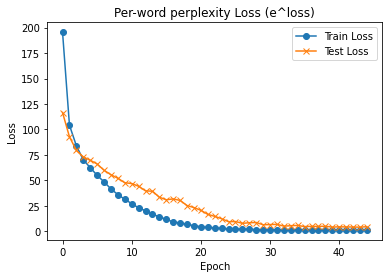

In [39]:
# Plotting metrics to see how model as learned and loss decreased
import numpy as np
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCHS), np.exp(trainLoss), marker='o')
plt.plot(range(N_EPOCHS), np.exp(testLoss), marker = 'x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.title("Per-word perplexity Loss (e^loss)")
#plt.ylim([0,1.5])
plt.show()

In [40]:
import os, pickle
import spacy

nlp = spacy.load('en')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
def questionAnswer(ques, SRC, TRG, model, maxLength = 100):
  model.eval()

  # tokenize
  tokenized = [tok.text.lower() for tok in nlp.tokenizer(ques)] 
  #print('tokenized: ', tokenized)

  # add <sos> and add <eos>
  tokenized = ['<sos>'] + tokenized + ['<eos>']
  #print('tokenized: ', tokenized)

  # convert to integer sequence using predefined tokenizer dictionary
  indexed = [SRC.vocab.stoi[t] for t in tokenized]        
  #print('indexed: ', indexed)

  # compute no. of words        
  length = [len(indexed)]
  #print('length : ', length)

  # convert to tensor                                    
  tensor = torch.LongTensor(indexed).to(device)   
  #print('tensor shape: ', tensor.shape)

  # reshape in form of batch, no. of words           
  tensor = tensor.unsqueeze(1) 
  #print('tensor shape: ', tensor.shape)


  with torch.no_grad():
    hidden, cell = model.encoder(tensor)

  #first input to the decoder is the <sos> tokens
  trg_indexes = [TRG.vocab.stoi[TRG.init_token]]

  for t in range(1, maxLength):
      
      trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
      #insert input token embedding, previous hidden and previous cell states
      #receive output tensor (predictions) and new hidden and cell states
      with torch.no_grad():
        output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
      
      #place predictions in a tensor holding predictions for each token
      #outputs[t] = output
      
      #decide if we are going to use teacher forcing or not
      #teacher_force = random.random() < teacher_forcing_ratio
      
      #get the highest predicted token from our predictions
      pred_token = output.argmax(1).item()
      #print(pred_token)


      trg_indexes.append(pred_token)

      if pred_token == TRG.vocab.stoi[TRG.eos_token]:
              break
      
  trg_tokens = [TRG.vocab.itos[i] for i in trg_indexes]
  words = trg_tokens[1:(len(trg_tokens)-1)]

  pred = ' '.join(words) 

  return pred

In [51]:
for j in range(10):
  i = random.randint(100,1000)
  print('*'*50)
  print('Input Quest    : ', dataset.Question[i])
  pred = questionAnswer(dataset.Question[i], SRC, TRG, model)
  print('Predicted Quest: ', pred)
  print('Actual Quest 2 : ', dataset.Answer[i])

**************************************************
Input Quest    :  Who also discovered that less than three percent of kangaroos exposed to the virus developed blindness ?
Predicted Quest:  veterinarians
Actual Quest 2 :  Veterinarians
**************************************************
Input Quest    :  Is Fillmore the first of two presidents to have been an indentured servant ?
Predicted Quest:  yes
Actual Quest 2 :  yes
**************************************************
Input Quest    :  When did Monroe's presidency expired?
Predicted Quest:  march 4 , 1825 .
Actual Quest 2 :  March 4, 1825
**************************************************
Input Quest    :  Does salmon remain the favorite of fly rod enthusiasts?
Predicted Quest:  yes
Actual Quest 2 :  Yes
**************************************************
Input Quest    :  Did ford get an award called "Congressman's congressman"?
Predicted Quest:  yes
Actual Quest 2 :  Yes
**************************************************
Input Q